In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
vehicles_paths = ['vehicles/GTI_Far/', 'vehicles/GTI_Left/', 'vehicles/GTI_MiddleClose/', 
                  'vehicles/GTI_Right/', 'vehicles/KITTI_extracted/']
non_vehicles_paths = ['non-vehicles/GTI/', 'non-vehicles/Extras/']

cars = []
notcars = []

#Load vehicle images
for path in vehicles_paths:    
    images = glob.glob(path + '*.png')

    for image in images:
        cars.append(image)

#Load non-vehicle images
for path in non_vehicles_paths:    
    images = glob.glob(path + '*.png')
    
    for image in images:
        notcars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    image = mpimg.imread(car_list[0])
    data_dict["image_shape"] = image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8667  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


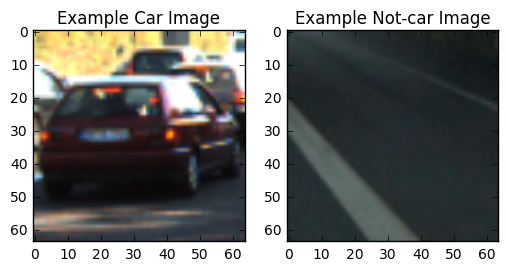

In [122]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [98]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32), vis = False):
    # Use cv2.resize().ravel() to create the feature vector
    image = cv2.resize(img, size)
    if vis == True:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(img)
        plt.title('Original')
        plt.subplot(122)
        plt.imshow(image)
        plt.title('Resized image')
    features = image.ravel() 
    
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
        
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block), 
                                transform_sqrt=False, visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block),
                        transform_sqrt=False, visualise=False, feature_vector=feature_vec)
        return features
    


In [32]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, 
                        viz=False, viz_only=False, hog_viz_name="", viz_title="HOG Viz"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if viz == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_image = get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                # Plot HOG visualisation
                
                if viz_only == True:
                    fig = plt.figure()
                    plt.imshow(hog_image)
                    plt.title(viz_title)
                    plt.savefig(hog_viz_name, bbox_inches='tight')
                    
                else:
                    fig = plt.figure()
                    plt.subplot(121)
                    plt.imshow(image)
                    plt.title('Example Image')
                    plt.subplot(122)
                    plt.imshow(hog_image)
                    plt.title('Example HOG ' + viz_title)
                    plt.savefig(hog_viz_name + "_double", bbox_inches='tight')
                
            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [84]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window_size = (64, 64)
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
scale = 1.5



[array([ 0.21334511,  0.48698986,  0.46040279, ...,  0.05411952,
         0.02408239,  0.03515546])]

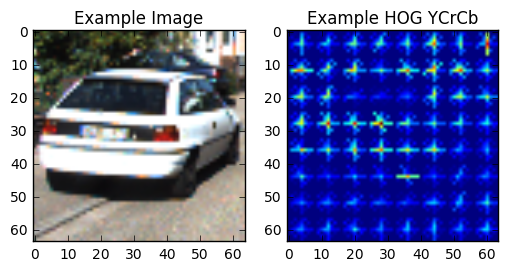

In [127]:
car_ind = np.random.randint(0, len(cars))
extract_features([cars[car_ind]], color_space=color_space, 
                 spatial_size=spatial_size, hist_bins=hist_bins, 
                 orient=orient, pix_per_cell=pix_per_cell, 
                 cell_per_block=cell_per_block, 
                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                 viz=True, viz_only=False, viz_title='YCrCb', hog_viz_name="output_images/YCrCb")


[array([ 0.15695491,  0.49364311,  0.44797155, ...,  0.08222149,
         0.        ,  0.00657189])]

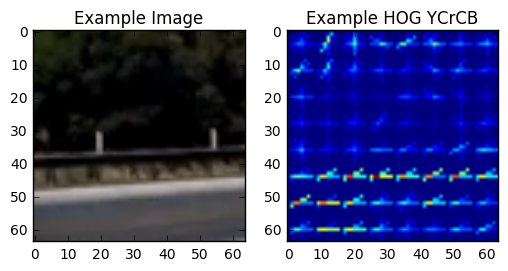

In [126]:
notcar_ind = np.random.randint(0, len(notcars))
extract_features([notcars[notcar_ind]], color_space=color_space, 
                 spatial_size=spatial_size, hist_bins=hist_bins, 
                 orient=orient, pix_per_cell=pix_per_cell, 
                 cell_per_block=cell_per_block, 
                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                 viz=True, viz_only=False, viz_title='YCrCB', hog_viz_name="output_images/YCrCb")


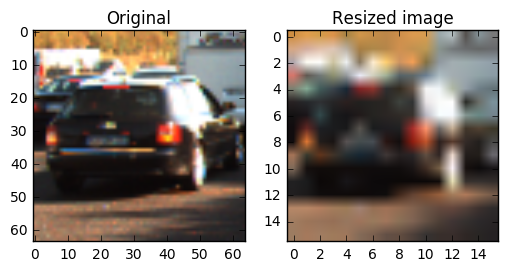

In [54]:
image = mpimg.imread(cars[car_ind])
spatial_features = bin_spatial(image, size=spatial_size, vis=True)
          


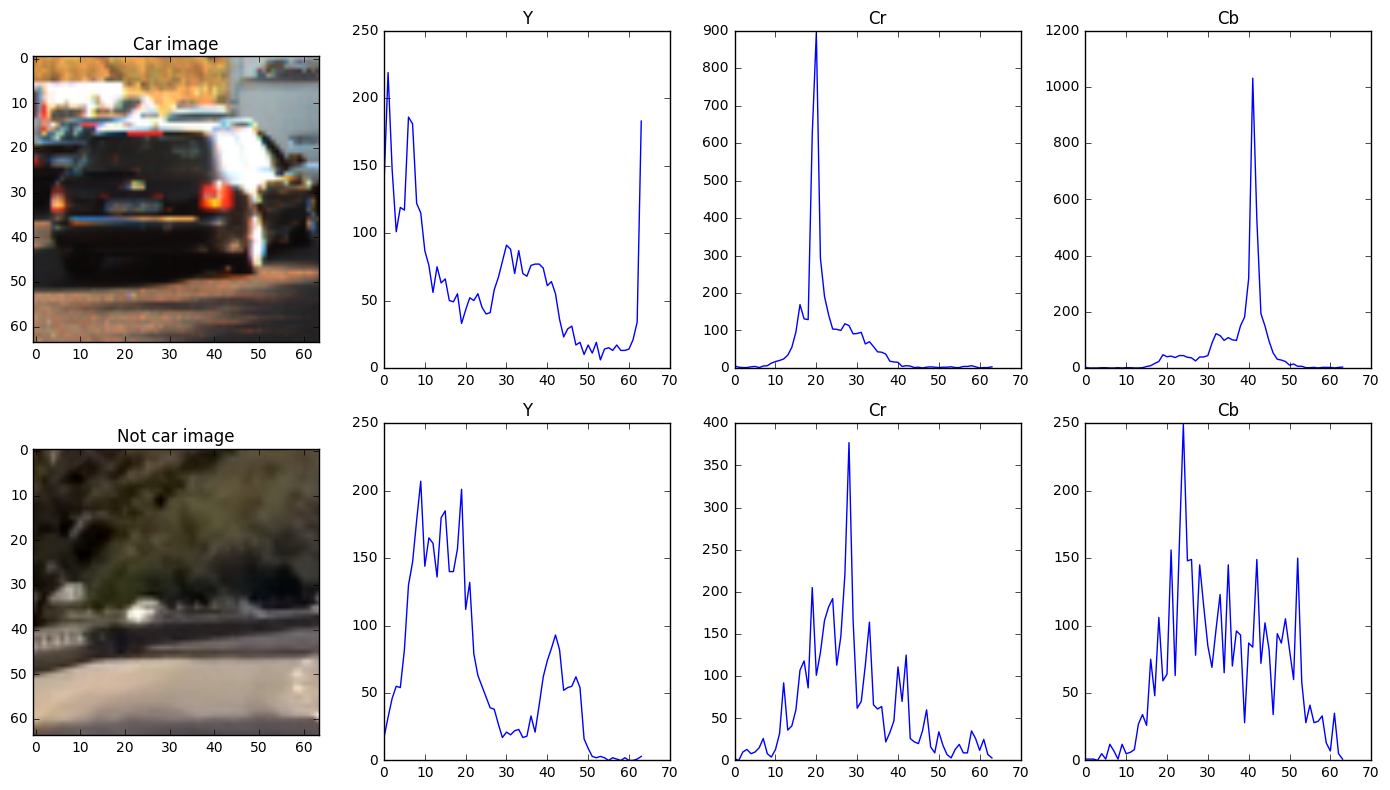

In [118]:
image = mpimg.imread(cars[car_ind])
featured_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
hist_car = color_hist(featured_image, nbins=hist_bins)

f, ax = plt.subplots(2, 4, figsize=(14,8))

color_size = (int)(hist_car.shape[0]/3)
a_car = hist_car[0:color_size]
b_car= hist_car[color_size:2*color_size]
c_car= hist_car[2*color_size:3*color_size]

ax[0][0].imshow(image)
ax[0][0].set_title('Car image')

ax[0][1].plot(a_car)
ax[0][2].plot(b_car)
ax[0][3].plot(c_car)

ax[0][1].set_title('Y')
ax[0][2].set_title('Cr')
ax[0][3].set_title('Cb')


image = mpimg.imread(notcars[notcar_ind])
featured_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
hist_notcar = color_hist(featured_image, nbins=hist_bins)

color_size = (int)(hist_notcar.shape[0]/3)
a_notcar = hist_notcar[0:color_size]
b_notcar= hist_notcar[color_size:2*color_size]
c_notcar= hist_notcar[2*color_size:3*color_size]

ax[1][0].imshow(image)
ax[1][0].set_title('Not car image')

ax[1][1].plot(a_notcar)
ax[1][2].plot(b_notcar)
ax[1][3].plot(c_notcar)

ax[1][1].set_title('Y')
ax[1][2].set_title('Cr')
ax[1][3].set_title('Cb')
f.tight_layout()





In [38]:
#Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=False, viz_only=False)
notcar_features =extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=False, viz_only=False)




(17635, 4488)


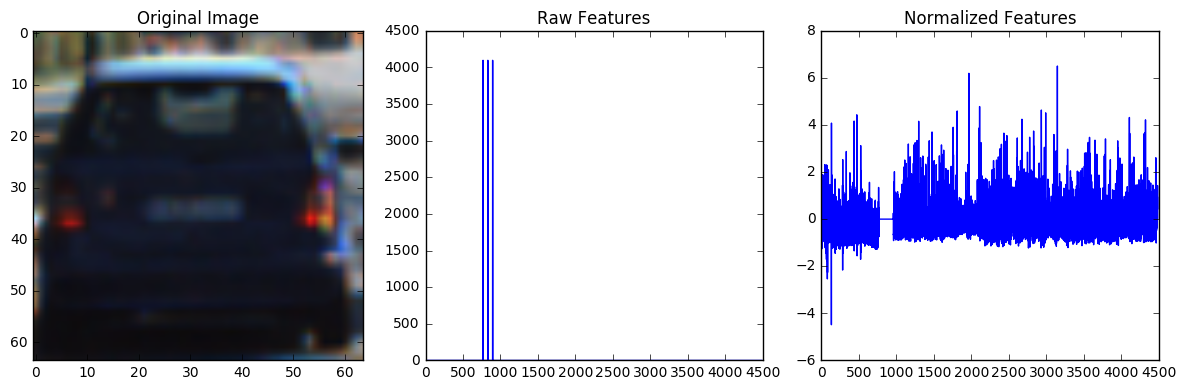

In [39]:
#Scale features
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print(X.shape)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [42]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))


In [43]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [15]:
from sklearn.externals import joblib
clf = SVC(C=10, kernel='rbf', gamma=0.0001)
    
# Check the training time for the SVC

clf.fit(X_train, y_train)

joblib.dump(clf, 'classifier2.pkl') 

['classifier2.pkl']

In [44]:
from sklearn.externals import joblib
clf = joblib.load('classifier2.pkl') 

In [45]:
preds = clf.predict(X_test)
accuracy = accuracy_score(preds, y_test)
print(accuracy)

0.999149418769


In [46]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hot_windows):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)))
            

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left, ytop_draw+ystart)
                down_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                cv2.rectangle(draw_img, top_left , down_right, (0,0,255),6) 
                
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                hot_windows.append((top_left, down_right))

    return draw_img, hot_windows

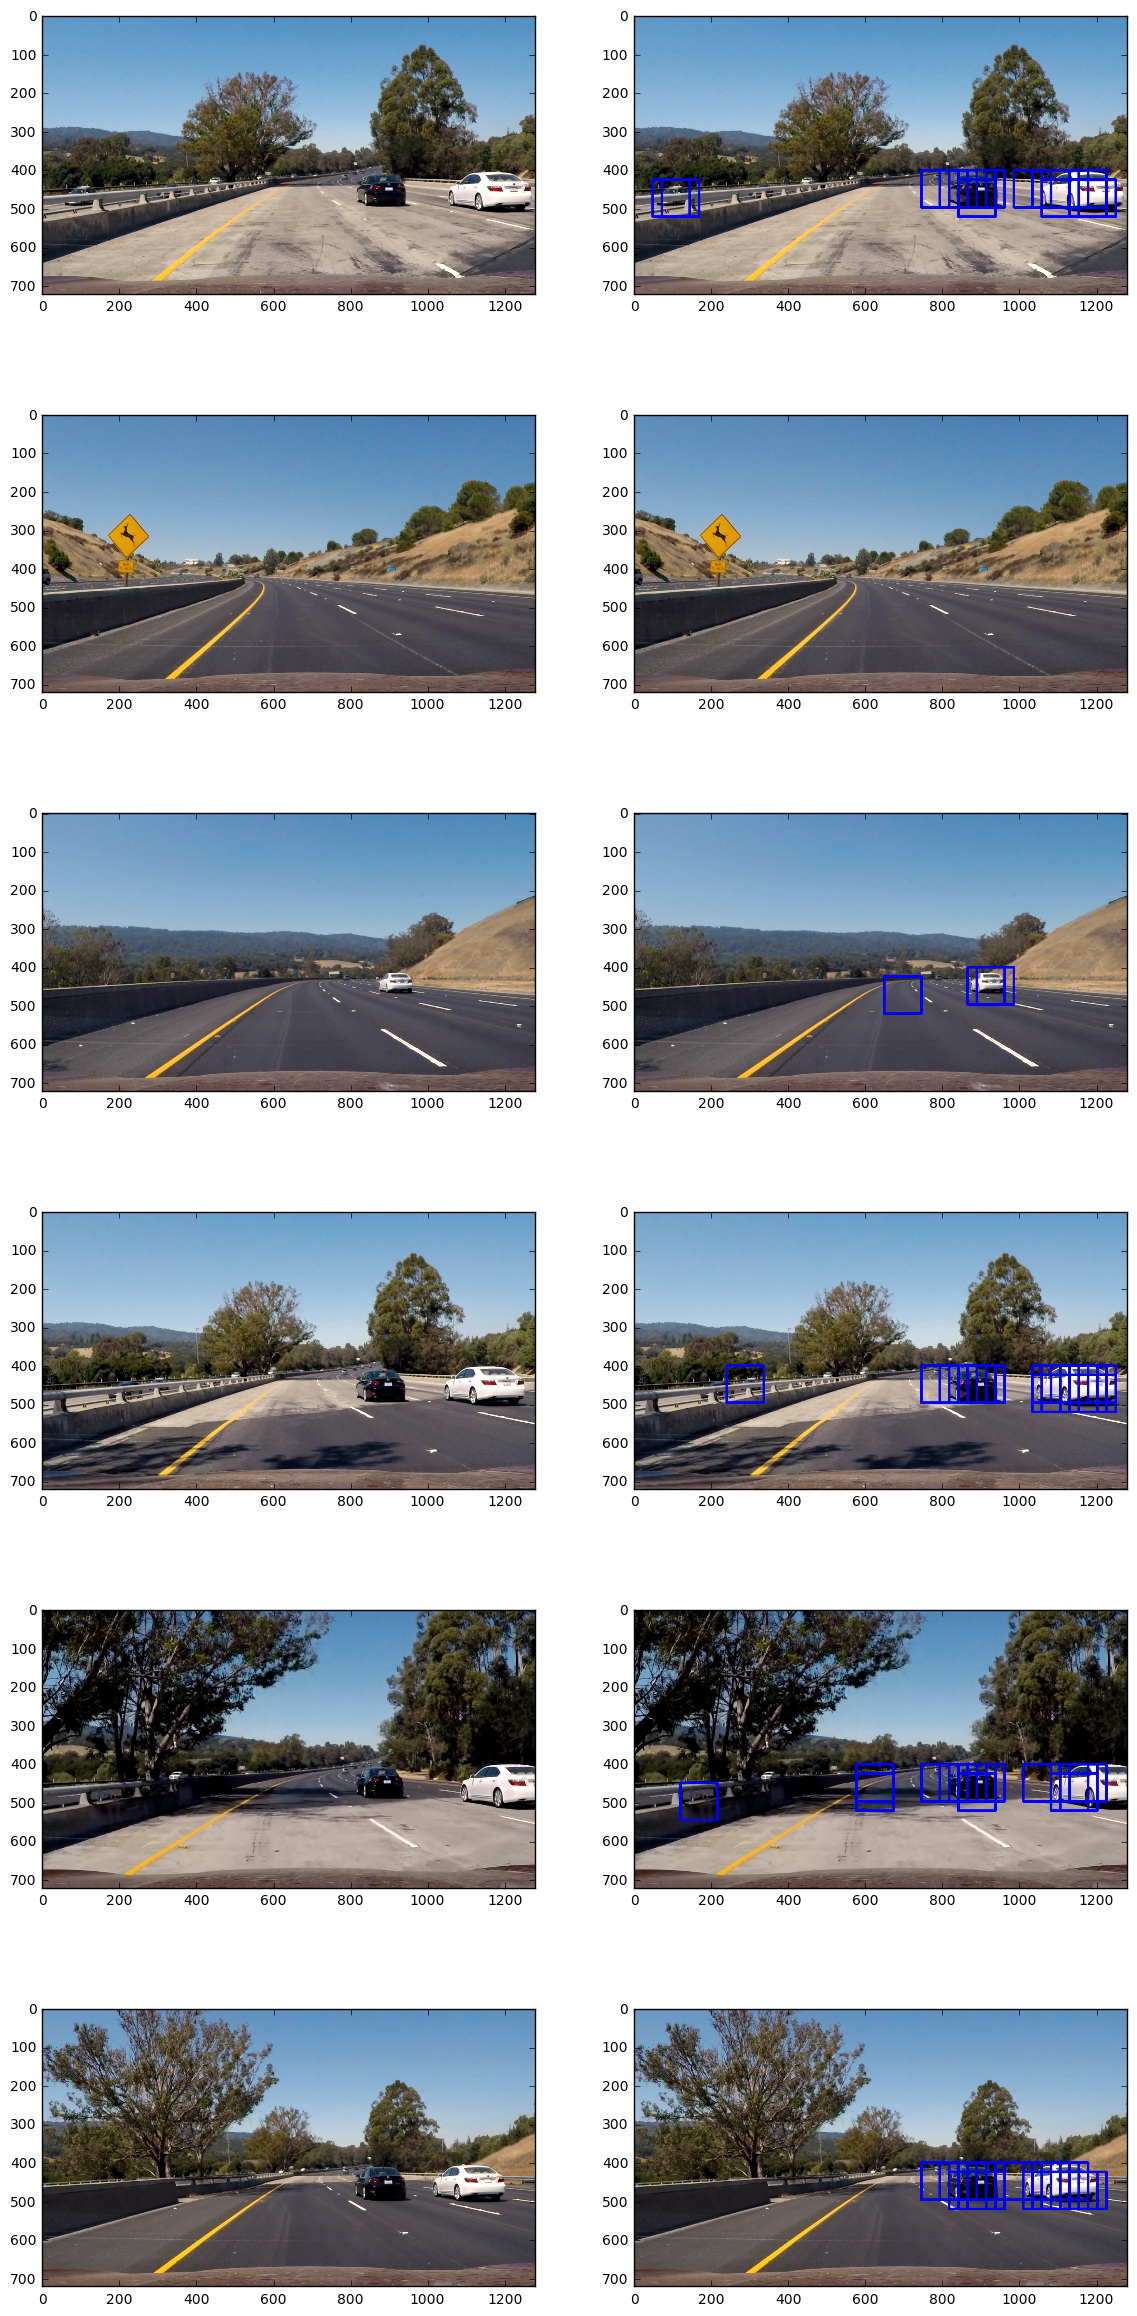

In [18]:
filenames = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(len(filenames),2, figsize=(14,30))

hot_windows = []
for i, filename in enumerate(filenames):
    image = mpimg.imread(filename)
    ax[i][0].imshow(image)
    
    image_classified, hot_windows = find_cars(img=image,ystart=y_start_stop[0],ystop=y_start_stop[1], scale=scale, svc=clf, X_scaler=X_scaler, orient=orient, 
                      pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins, hot_windows=hot_windows)
    ax[i][1].imshow(image_classified)

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

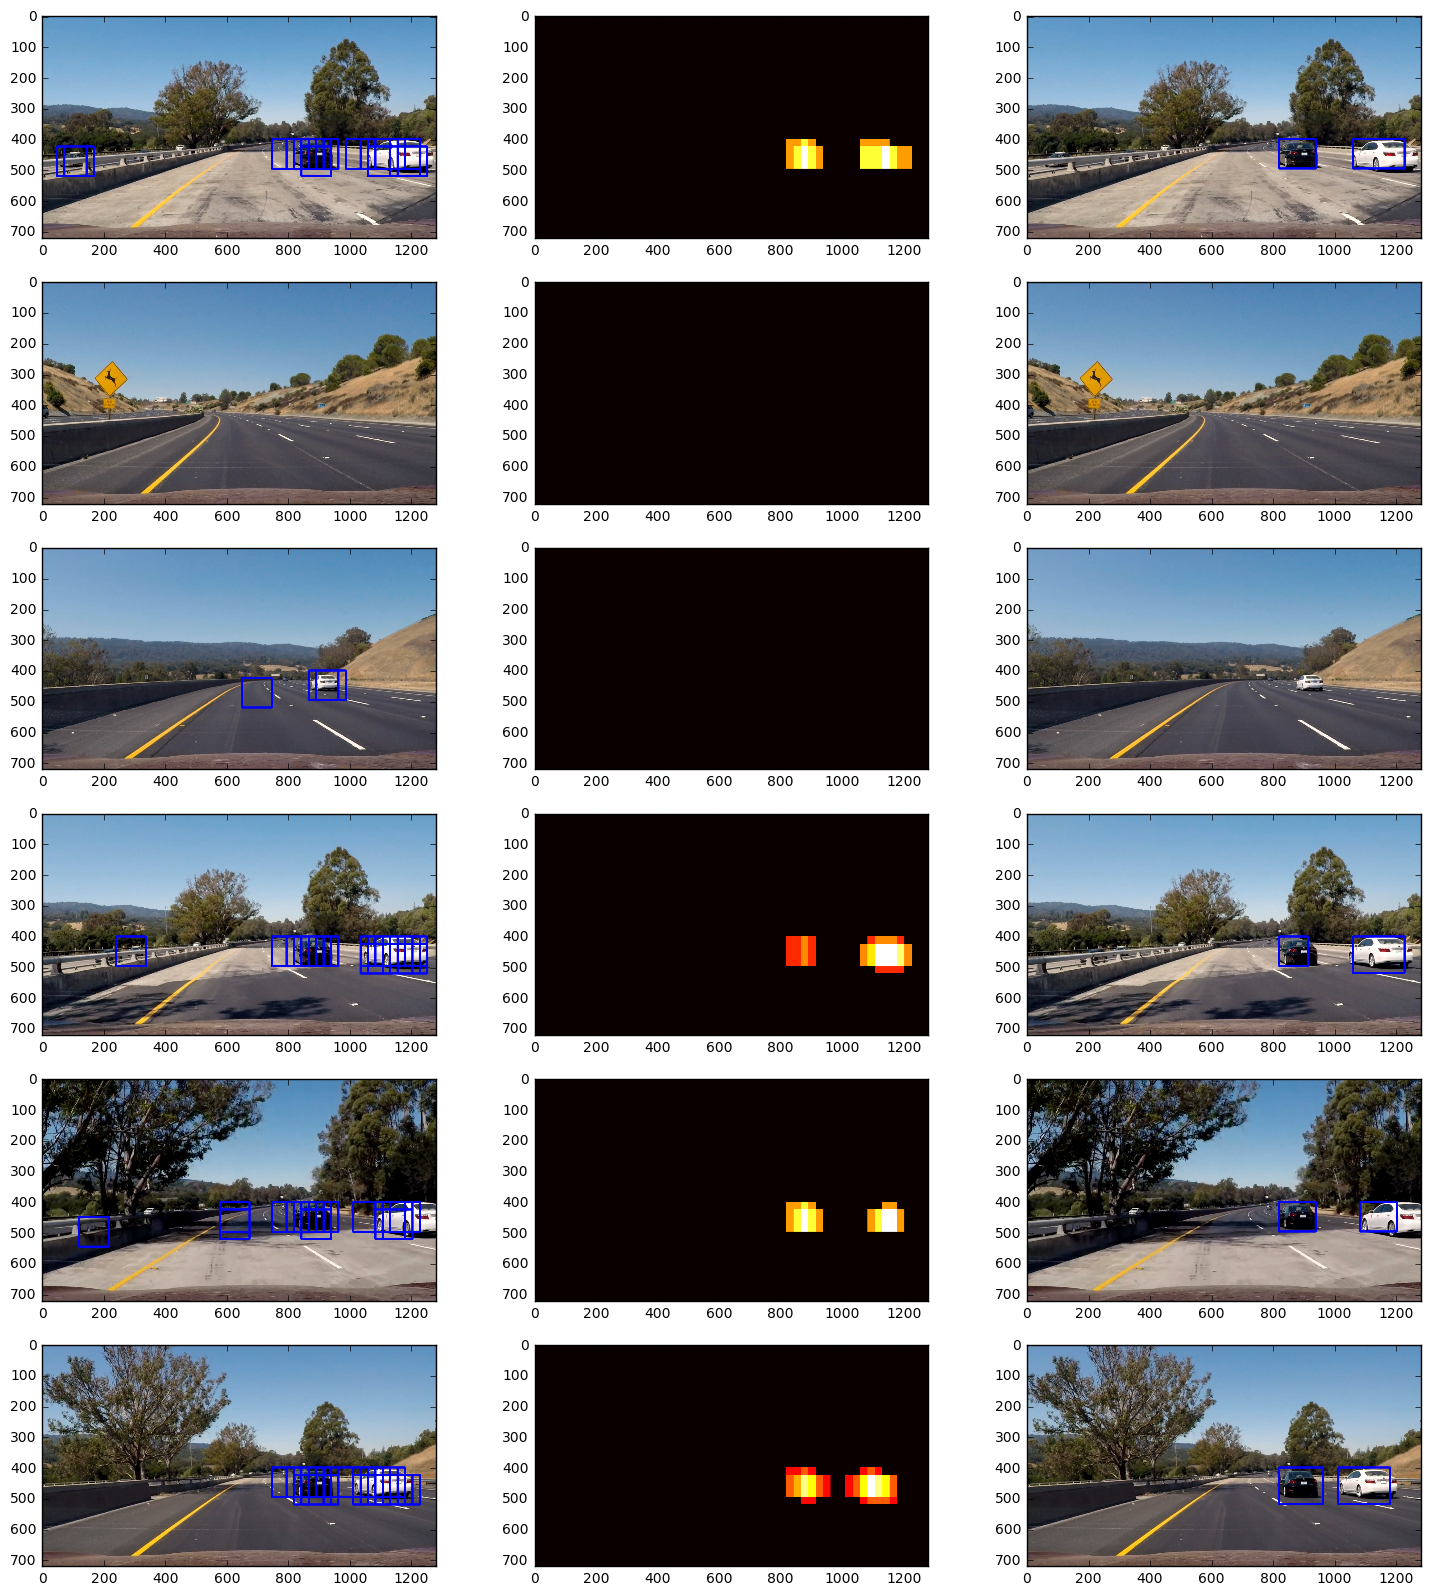

In [22]:
filenames = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(len(filenames),3, figsize=(18,20))
#hot_windows = []
for i, filename in enumerate(filenames):
    hot_windows = []
    image = mpimg.imread(filename)
    #ax[i][0].imshow(image)
    image_classified, hot_windows = find_cars(img=image,ystart=y_start_stop[0],ystop=y_start_stop[1], scale=scale, svc=clf, X_scaler=X_scaler, orient=orient, 
                      pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins, hot_windows=hot_windows)
    ax[i][0].imshow(image_classified)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    ax[i][1].imshow(heatmap, cmap='hot')
    ax[i][2].imshow(draw_img)
    
    heatmap = 0

## VIDEO

In [39]:
def process_image(image):
    global bboxes_list
    hot_windows = []
    recent_frames_used = 5

    image_classified, hot_windows = find_cars(img=image,ystart=y_start_stop[0],ystop=y_start_stop[1], scale=scale, svc=clf, X_scaler=X_scaler, orient=orient, 
                      pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins, hot_windows=hot_windows)
    
    bboxes_list.append(hot_windows)
    
    # Adjust parameters if needed
    if len(bboxes_list) < recent_frames_used + 1:
        recent_frames_used = len(bboxes_list) - 1  
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    #heat = add_heat(heat,hot_windows)

    for boxlist in bboxes_list[-recent_frames_used:]:
        heat = add_heat(heat, boxlist)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [40]:
bboxes_list = []
project_output = 'output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output2.mp4
[MoviePy] Writing video output2.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:43:13<00:03,  3.99s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output2.mp4 

Wall time: 1h 43min 14s


In [41]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))